In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity  # display as density curves

import torch
from geomloss import SamplesLoss

import os
import sys
import pandas as pd
import glob
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

savefigs = True
pfp = '/home/ngr4/project/dist_encoder/results/'

# Square dist

In [22]:
N, M = (500, 500)

t_i = torch.linspace(0, 1, M).view(-1,1)
t_j = torch.linspace(0, 1, M).view(-1,1)

X_i, Y_j  = .1 * t_i, .2 * t_j + .8  # Intervals [0., 0.1] and [.8, 1.].

In [23]:
t_k = torch.linspace(0, 1, N).view(-1,1)
Z_k = t_k

In [24]:
t_plot = np.linspace(-0.1, 1.1, 1000)[:,np.newaxis]

def display_samples(ax, x, color, weights=None, blur=.002):
    """Displays samples on the unit interval using a density curve."""
    kde  = KernelDensity(kernel='gaussian', bandwidth= blur ).fit(
            x.data.cpu().numpy(),
            sample_weight = None if weights is None else weights.data.cpu().numpy())
    dens = np.exp( kde.score_samples(t_plot) )
    dens[0] = 0 ; dens[-1] = 0
    ax.fill(t_plot, dens, color=color)

In [25]:
import os
import torch
import matplotlib
import matplotlib.pyplot as plt
from math import isnan
import numpy as np
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore",".*GUI is implemented.*") # annoying warning with pyplot and pause...

In [26]:
warnings.filterwarnings("ignore",".*GUI is implemented.*") # annoying warning with pyplot and pause...

def mypause(interval):
    """Pause matplotlib without stealing focus."""
    backend = plt.rcParams['backend']
    if backend in matplotlib.rcsetup.interactive_bk:
        figManager = matplotlib._pylab_helpers.Gcf.get_active()
        if figManager is not None:
            canvas = figManager.canvas
            if canvas.figure.stale:
                canvas.draw()
            canvas.start_event_loop(interval)
            return


def model_to_numpy(model, grad=False) :
    """
    The fortran routines used by scipy.optimize expect float64 vectors
    instead of the gpu-friendly float32 matrices: we need conversion routines.
    """
    if not all( param.is_contiguous() for param in model.parameters() ) :
        raise ValueError("Scipy optimization routines are only compatible with parameters given as *contiguous* tensors.")

    if grad :
        tensors = [param.grad.data.view(-1).cpu().numpy() for param in model.parameters()]
    else :
        tensors = [param.data.view(-1).cpu().numpy()      for param in model.parameters()]
    return np.ascontiguousarray( np.hstack(tensors) , dtype='float64' )

def numpy_to_model(model, vec) :
    i = 0
    for param in model.parameters() :
        offset = param.numel()
        param.data = torch.from_numpy(vec[i:i+offset]).view(param.data.size()).type(param.data.type())
        i += offset

    if i != len(vec) :
        raise ValueError("The total number of variables in model is not the same as in 'vec'.")

def fit_model(Model, method = "L-BFGS", tol = 1e-10, nits = 500, nlogs = 10,
                     lr = .1, eps = .01, maxcor = 10, gtol = 1e-10, 
                     display = False, **params) :
    """
    """

    # Load parameters =====================================================================================================


    # We'll minimize the model's cost
    # with respect to the model's parameters using a standard gradient-like
    # descent scheme. As we do not perform any kind of line search, 
    # this algorithm may diverge if the learning rate is too large !
    # For robust optimization routines, you may consider using
    # the scipy.optimize API with a "parameters <-> float64 vector" wrapper.
    use_scipy = False
    if method == "Adam" :
        optimizer = torch.optim.Adam(Model.parameters(), lr=lr, eps=eps)
    elif method == "L-BFGS" :
        optimizer = torch.optim.SGD(Model.parameters(), lr=1.) # We'll just use its "zero_grad" method...

        use_scipy = True
        method    = 'L-BFGS-B'
        options   = dict( maxiter = nits,
                          ftol    = tol,          # Don't bother fitting the shapes to float precision
                          gtol    = gtol,
                          maxcor  = maxcor        # Number of previous gradients used to approximate the Hessian
                    )
    else :
        raise NotImplementedError('Optimization method not supported : "'+method+'". '\
                                  'Available values are "Adam" and "L-BFGS".')

    costs = []
    # Define the "closures" associated to our model =======================================================================

    fit_model.nit = -1 ; fit_model.breakloop = False
    def closure(final_it=False):
        """
        Encapsulates a problem + display iteration into a single callable statement.
        This wrapper is needed if you choose to use LBFGS-like algorithms, which
        (should) implement a careful line search along the gradient's direction.
        """
        fit_model.nit += 1 ; it = fit_model.nit
        # Minimization loop --------------------------------------------------------------------
        optimizer.zero_grad()                      # Reset the gradients (PyTorch syntax...).
        cost = Model.forward()
        costs.append(cost.item())  # Store the "cost" for plotting.
        cost.backward()            # Backpropagate to compute the gradient.
        # Break the loop if the cost's variation is below the tolerance param:
        if ( len(costs)>1 and abs(costs[-1]-costs[-2]) < tol ) or fit_model.nit == nits-1:
            fit_model.breakloop = True
        
        if display:

            Model.plot(nit=fit_model.nit, cost=cost.item())
            # print("{}: {:2.4f}".format(fit_model.nit, cost.item()))
        return cost
    
    # Scipy-friendly wrapper ------------------------------------------------------------------------------------------------
    def numpy_closure(vec, final_it=False) :
        """
        Wraps the PyTorch closure into a 'float64'-vector routine,
        as expected by scipy.optimize.
        """
        vec    = lr * vec.astype('float64')            # scale the vector, and make sure it's given as float64
        numpy_to_model(Model, vec)                     # load this info into Model's parameters
        c      = closure(final_it).item()              # compute the cost and accumulate the gradients wrt. the parameters
        dvec_c = lr * model_to_numpy(Model, grad=True) # -> return this gradient, as a properly rescaled numpy vector
        return (c, dvec_c)

    # Actual minimization loop ===============================================================================================
    if use_scipy :
        res = minimize( numpy_closure,      # function to minimize
                model_to_numpy(Model), # starting estimate
                method  = method,
                jac     = True,             # matching_problems also returns the gradient
                options = options    )
        numpy_closure(res.x, final_it=True) 
        # print(res.message)
    else :
        for i in range(nits+1) :            # Fixed number of iterations
            optimizer.step(closure)         # "Gradient descent" step.
            if fit_model.breakloop :
                closure(final_it=True) 
                break
            

In [27]:

from torch.nn import Module, Parameter  # PyTorch syntax for optimization problems

class Barycenter(Module):
    """Abstract model for the computation of Sinkhorn barycenters."""

    def __init__(self, loss, w=.5):
        super(Barycenter, self).__init__()
        self.loss = loss   # Sinkhorn divergence to optimize
        self.w = w         # Interpolation coefficient
        # We copy the reference starting points, to prevent in-place modification:
        self.x_i, self.y_j, self.z_k = X_i.clone(), Y_j.clone(), Z_k.clone()

    def fit(self, display=False, tol=1e-10):
        """Uses a custom wrapper around the scipy.optimize module."""
        fit_model(self, method = "L-BFGS", lr = 1., display = display, tol=tol, gtol=tol)

    def weights(self):
        """The default weights are uniform, equal to 1/N."""
        return (torch.ones(len(self.z_k)) / len(self.z_k)).type_as(self.z_k)

    def plot(self, nit=0, cost=0, ax=None, title=None):
        """Displays the descent using a custom 'waffle' layout.

        N.B.: As the L-BFGS descent typically induces high-frequencies in
              the optimization process, we blur the 'interpolating' measure
              a little bit more than the two endpoints.
        """
        if ax is None:
            if nit == 0 or nit % 16 == 4:
                plt.pause(.01)
                plt.figure(figsize=(16,4))

            if nit <= 4 or nit % 4 == 0:
                if nit < 4: index = nit + 1
                else:       index = (nit//4 - 1) % 4 + 1
                ax = plt.subplot(1,4, index)

        if ax is not None:
            display_samples(ax, self.x_i, (.95,.55,.55))
            display_samples(ax, self.y_j, (.55,.55,.95))
            display_samples(ax, self.z_k, (.55,.95,.55), weights = self.weights(), blur=.005)

            if title is None:
                ax.set_title("nit = {}, cost = {:3.4f}".format(nit, cost))
            else:
                ax.set_title(title)

            ax.axis([-.1,1.1,-.1,20.5])
            ax.set_xticks([], []); ax.set_yticks([], [])
            plt.tight_layout()


class EulerianBarycenter(Barycenter) :
    """Barycentric model with fixed locations z_k, as we optimize on the log-weights l_k."""
    def __init__(self, loss, w=.5) :
        super(EulerianBarycenter, self).__init__(loss, w)

        # We're going to work with variable weights, so we should explicitely
        # define the (uniform) weights on the "endpoint" samples:
        self.a_i = (torch.ones(len(self.x_i)) / len(self.x_i)).type_as(self.x_i)
        self.b_j = (torch.ones(len(self.y_j)) / len(self.y_j)).type_as(self.y_j)

        # Our parameter to optimize: the logarithms of our weights
        self.l_k = Parameter( torch.zeros(len(self.z_k)).type_as(self.z_k) )

    def weights(self):
        """Turns the l_k's into the weights of a positive probabilty measure."""
        return torch.nn.functional.softmax(self.l_k, dim=0)

    def forward(self) :
        """Returns the cost to minimize."""
        c_k  = self.weights()
        return self.w  * self.loss(c_k, self.z_k, self.a_i, self.x_i) \
        + (1 - self.w) * self.loss(c_k, self.z_k, self.b_j, self.y_j)

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

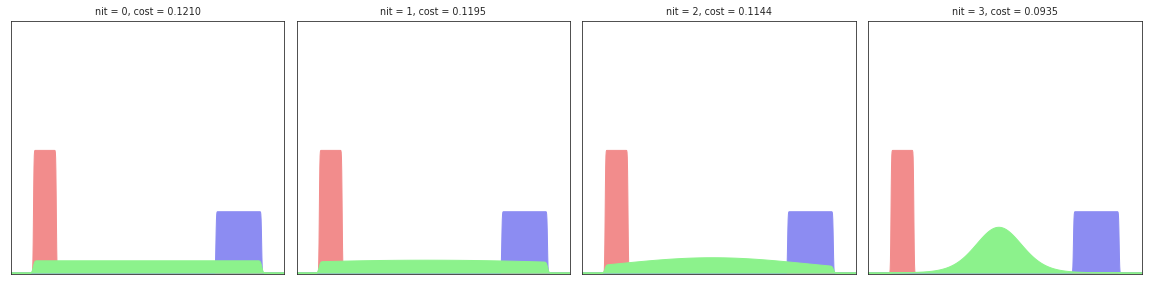

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

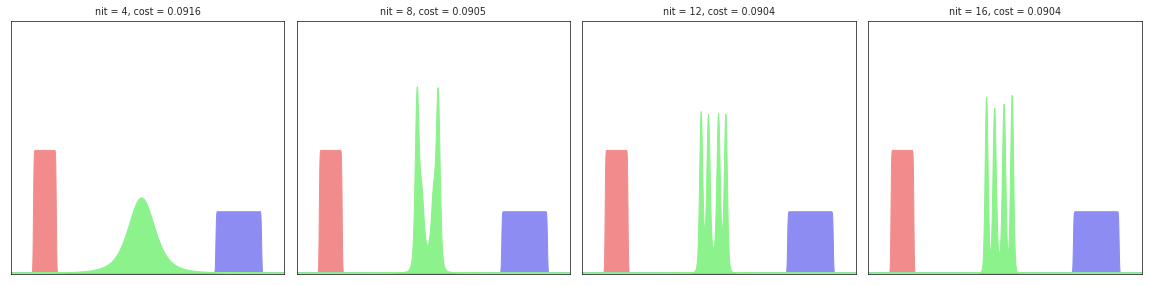

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

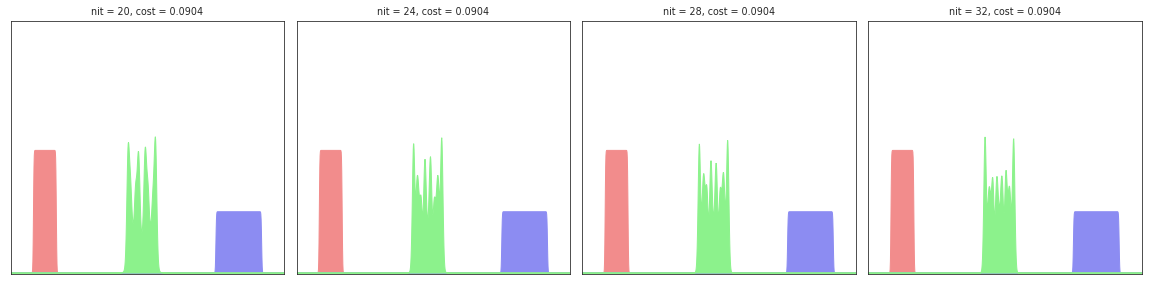

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

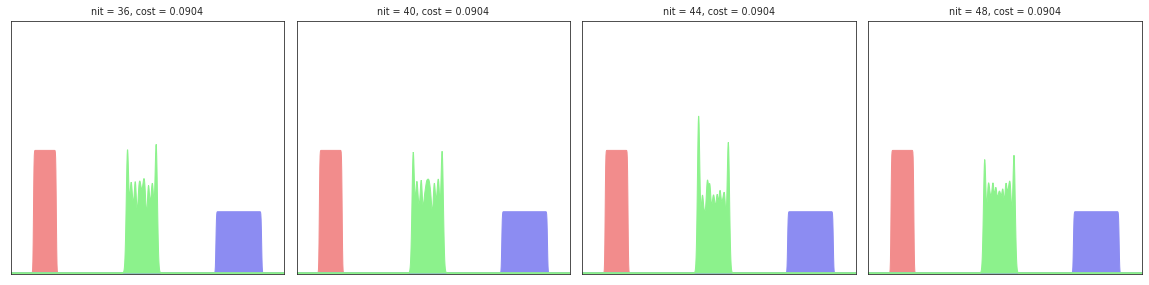

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

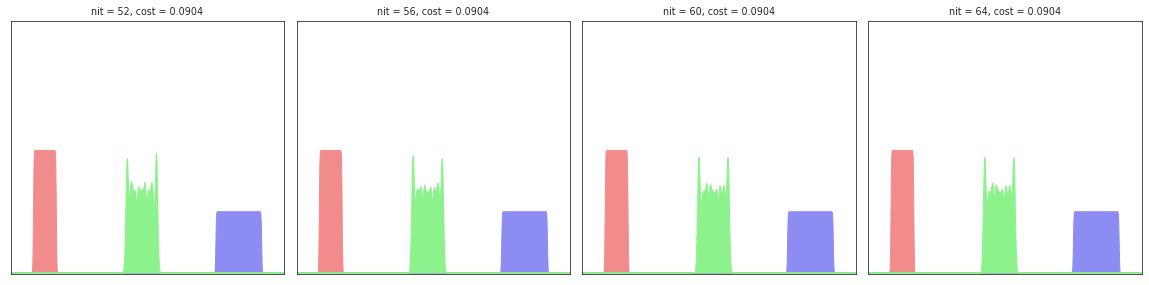

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

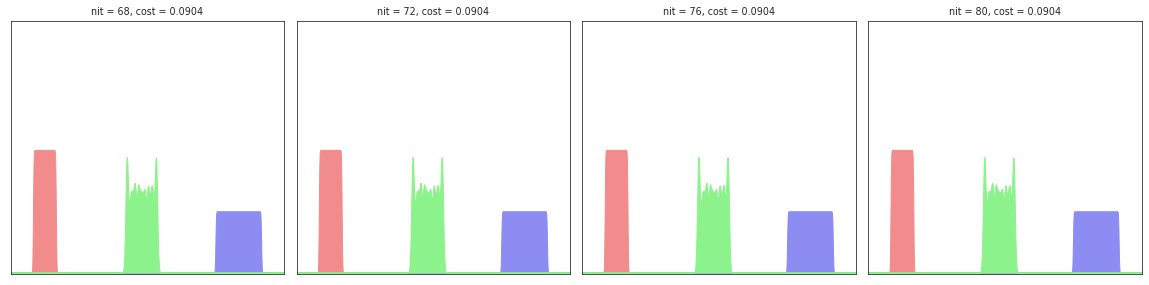

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

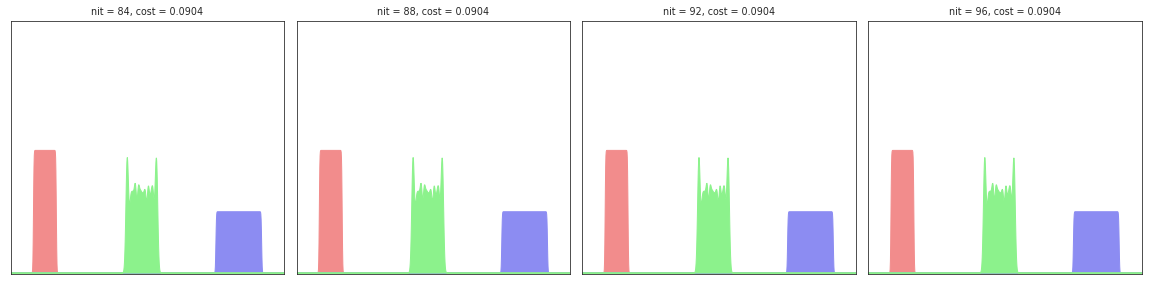

In [28]:
EB = EulerianBarycenter( SamplesLoss("sinkhorn", blur=.001, scaling=.99) )
EB.fit(display=True)

/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

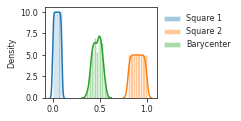

In [30]:
# get distributions out 
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.distplot(X_i, label='Square 1', ax = ax)
sns.distplot(Y_j, label='Square 2', ax = ax)

# get barycenter
weights = torch.nn.functional.softmax(EB.l_k, dim=0)
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 
sns.distplot(z_sampled, label='Barycenter', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(os.path.join(pfp, 'barycenter_squares.pdf'), bbox_inches='tight')

In [32]:
import torch.nn as nn

In [33]:
# grab encodings 
# models

class Set2Set(nn.Module):
    def __init__(self, input_dim, hidden_dim, act_fn=nn.Tanh, num_layers=1):
        '''
        Args:
            input_dim: input dim of Set2Set. 
            hidden_dim: the dim of set representation, which is also the INPUT dimension of 
                the LSTM in Set2Set. 
                This is a concatenation of weighted sum of embedding (dim input_dim), and the LSTM
                hidden/output (dim: self.lstm_output_dim).
        '''
        super(Set2Set, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        if hidden_dim <= input_dim:
            print('ERROR: Set2Set output_dim should be larger than input_dim')
        # the hidden is a concatenation of weighted sum of embedding and LSTM output
        self.lstm_output_dim = hidden_dim - input_dim
        self.lstm = nn.LSTM(hidden_dim, input_dim, num_layers=num_layers, batch_first=True)

        # convert back to dim of input_dim
       # self.pred = nn.Linear(hidden_dim, input_dim)
        self.pred = nn.Linear(hidden_dim,4)
        self.act = act_fn()

    def forward(self, embedding):
        '''
        Args:
            embedding: [batch_size x n x d] embedding matrix
        Returns:
            aggregated: [batch_size x d] vector representation of all embeddings
        '''
        batch_size = embedding.size()[0]
        n = embedding.size()[1]

        hidden = (torch.zeros(self.num_layers, batch_size, self.lstm_output_dim).cuda(),
                  torch.zeros(self.num_layers, batch_size, self.lstm_output_dim).cuda())

        q_star = torch.zeros(batch_size, 1, self.hidden_dim).cuda()
        for i in range(n):
            # q: batch_size x 1 x input_dim
            q, hidden = self.lstm(q_star, hidden)
            # e: batch_size x n x 1
            e = embedding @ torch.transpose(q, 1, 2)
            a = nn.Softmax(dim=1)(e)
            r = torch.sum(a * embedding, dim=1, keepdim=True)
            q_star = torch.cat((q, r), dim=2)
        q_star = torch.squeeze(q_star, dim=1)
        out = self.act(self.pred(q_star))

        return out
    
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ELU(inplace=True),
            nn.Linear(50, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 10),
            nn.ELU(inplace=True),
            nn.Linear(10, 2),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x
   
class Encoder(nn.Module):
    """ Set Encoder 
    """
    def __init__(self, dim_Q, dim_K, dim_V, d_model, num_heads, ln=False, skip=True):
        super(Encoder, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.skip = skip
       # self.s_max = s_max
        #Maximum set size
        self.d_model = d_model
        self.fc_q = nn.Linear(dim_Q, d_model)
        self.fc_k = nn.Linear(dim_K, d_model)
        self.fc_v = nn.Linear(dim_K, d_model)
        if ln:
            self.ln0 = nn.LayerNorm(d_model)
            self.ln1 = nn.LayerNorm(d_model)
        #This is the classic pointwise feedforward in "Attention is All you need"
        self.ff = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.ReLU(),
        nn.Linear(4 * d_model, d_model))
        # I have experimented with just a smaller version of this 
       # self.fc_o = nn.Linear(d_model,d_model)
        
     #   self.fc_rep = nn.Linear(s_max, 1)
    #number of heads must divide output size = d_model
        

    def forward(self, Q, K):
        Q = self.fc_q(Q)
      
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.d_model // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
  

        A = torch.softmax(Q_.bmm(K_.transpose(-2,-1))/math.sqrt(self.d_model), dim=-1)
        A_1 = A.bmm(V_)
        
 
        O = torch.cat((A_1).split(Q.size(0), 0), 2)
       
        O = torch.cat((Q_ + A_1).split(Q.size(0), 0), 2) if getattr(self, 'skip', True) else \
             torch.cat((A_1).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
       # O = O + F.relu(self.fc_o(O)) if getattr(self, 'skip', None) is None else F.relu(self.fc_o(O))
        # For the classic transformers paper it is 
        O = O + self.ff(O)
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        O = torch.mean(O,dim=1)
#         O = pad_sequence(O, batch_first=True, padding_value=0)
#         O = O.transpose(-2,-1)
#         O = F.pad(O, (0, self.s_max- O.shape[-1]), 'constant', 0)
      #  O = self.fc_rep(O)
       # O = self.fc_rep(O.transpose(-2,-1))
      #  O = O.squeeze()

        return O
    
    
class SelfAttention(nn.Module):
    def __init__(self, dim_in=18, dim_out=8, num_heads=2, ln=True, skip=True):
        super(SelfAttention, self).__init__()
        self.Encoder = Encoder(dim_in, dim_in, dim_in, dim_out, num_heads, ln=ln, skip=skip)

    def forward(self, X):
        return self.Encoder(X, X)
    



In [34]:
# utils

eps = 1e-15
"""Approximating KL divergences between two probability densities using samples. 
    It is buggy. Use at your own peril
"""

def knn_distance(point, sample, k):
    """ Euclidean distance from `point` to it's `k`-Nearest
    Neighbour in `sample` """
    norms = np.linalg.norm(sample-point, axis=1)
    return np.sort(norms)[k]


def verify_sample_shapes(s1, s2, k):
    # Expects [N, D]
    assert(len(s1.shape) == len(s2.shape) == 2)
    # Check dimensionality of sample is identical
    assert(s1.shape[1] == s2.shape[1])


def naive_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using brute-force (numpy) k-NN
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    D = np.log(m / (n - 1))
    d = float(s1.shape[1])

    for p1 in s1:
        nu = knn_distance(p1, s2, k-1)  # -1 because 'p1' is not in 's2'
        rho = knn_distance(p1, s1, k)
        D += (d/n)*np.log((nu/rho)+eps)
    return D


def scipy_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scipy's KDTree
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    nu_d,  nu_i   = KDTree(s2).query(s1, k)
    rho_d, rhio_i = KDTree(s1).query(s1, k+1)

    # KTree.query returns different shape in k==1 vs k > 1
    if k > 1:
        D += (d/n)*np.sum(np.log(nu_d[::, -1]/rho_d[::, -1]))
    else:
        D += (d/n)*np.sum(np.log(nu_d/rho_d[::, -1]))

    return D


def skl_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scikit-learn's NearestNeighbours
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    s1_neighbourhood = NearestNeighbors(k+1, 10).fit(s1)
    s2_neighbourhood = NearestNeighbors(k, 10).fit(s2)

    for p1 in s1:
        s1_distances, indices = s1_neighbourhood.kneighbors([p1], k+1)
        s2_distances, indices = s2_neighbourhood.kneighbors([p1], k)
        rho = s1_distances[0][-1]
        nu = s2_distances[0][-1]
        D += (d/n)*np.log(nu/rho)
    return D


# List of all estimators
Estimators = [naive_estimator, scipy_estimator, skl_estimator]


class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).to(device).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).to(device).squeeze()

        u = torch.zeros_like(mu).to(device)
        v = torch.zeros_like(nu).to(device)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

      #  return cost, pi, C
        return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=1):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [35]:
# initialize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepSet(1, 36).to(device)
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to(device)

model.load_state_dict(torch.load(os.path.join('/home/ngr4/project/dist_encoder/notebooks_and_pkl/', 'deepset_dist_flat6.pkl')))
model.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [57]:
# store results
embeddings = pd.DataFrame()
embeddings.loc['Square-1', ['X', 'Y']] = model(X_i.view(1, -1, 1)).detach().numpy()
embeddings.loc['Square-2', ['X', 'Y']] = model(Y_j.view(1, -1, 1)).detach().numpy()
embeddings.loc['Barycenter (squares)', ['X', 'Y']] = model(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()


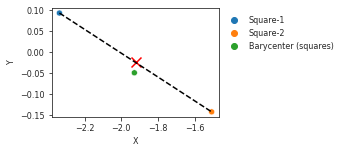

In [79]:
# plot the embedded space 
fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.plot([embeddings.loc['Square-1', 'X'], embeddings.loc['Square-2', 'X']],
         [embeddings.loc['Square-1', 'Y'], embeddings.loc['Square-2', 'Y']],
        'k--')
ax.scatter((embeddings.loc['Square-1', 'X'] + embeddings.loc['Square-2', 'X'])/2,
            (embeddings.loc['Square-1', 'Y'] + embeddings.loc['Square-2', 'Y'])/2,
           color='r', marker='x', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings.reset_index(),
                ax=ax)
ax.legend(bbox_to_anchor=(1,1))
fig.savefig(os.path.join(pfp, 'barycenter_embedding+midpt.pdf'),  bbox_inches='tight')

# Dirac dist

In [76]:
X_i, Y_j  = torch.zeros(500).view(-1, 1), torch.ones(500).view(-1, 1)# Intervals [0., 0.1] and [.8, 1.].

t_k = torch.linspace(-.1, 1.1, 500).view(-1,1)
Z_k = t_k

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

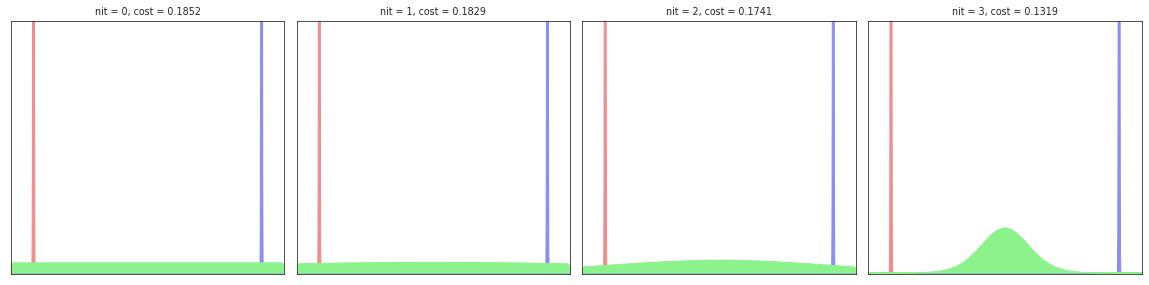

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

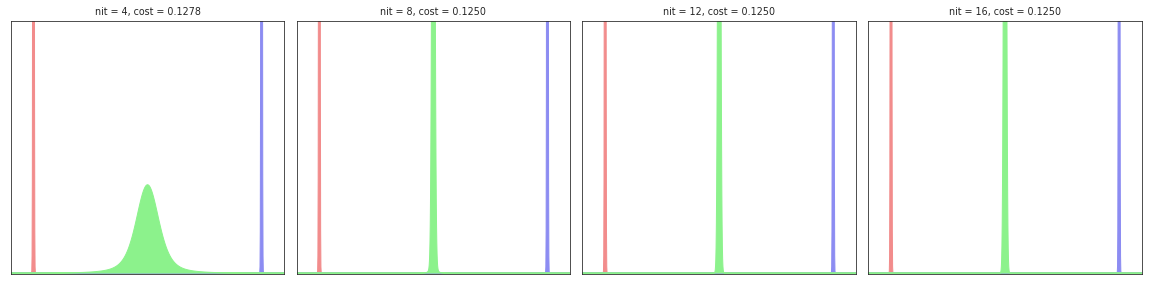

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

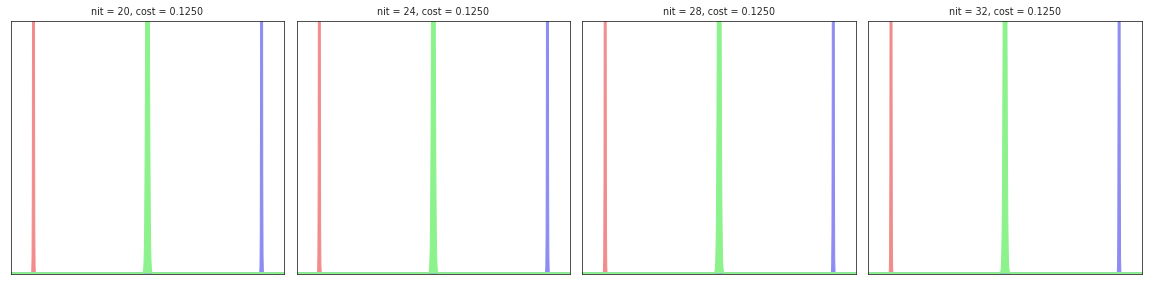

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

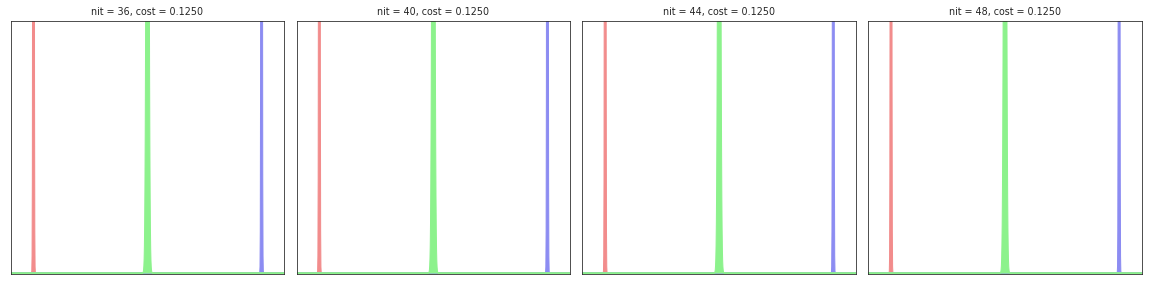

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])


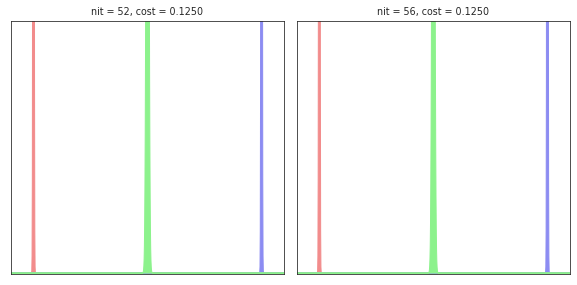

In [77]:
EB = EulerianBarycenter( SamplesLoss("sinkhorn", blur=.001, scaling=.99) )
EB.fit(display=True)

/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/gpfs/ycga/projec

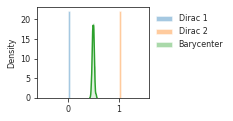

In [80]:
# get distributions out 
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.distplot(X_i, label='Dirac 1', ax = ax)
sns.distplot(Y_j, label='Dirac 2', ax = ax)

# get barycenter
weights = torch.nn.functional.softmax(EB.l_k, dim=0)
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 
sns.distplot(z_sampled, label='Barycenter', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(os.path.join(pfp, 'barycenter_dirac.pdf'), bbox_inches='tight')

In [81]:
# add data
embeddings.loc['Dirac-1', ['X', 'Y']] = model(X_i.view(1, -1, 1)).detach().numpy()
embeddings.loc['Dirac-2', ['X', 'Y']] = model(Y_j.view(1, -1, 1)).detach().numpy()
embeddings.loc['Barycenter (Diracs)', ['X', 'Y']] = model(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()


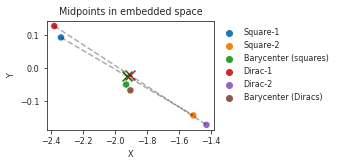

In [89]:
# plot the embedded space 67trrrf55
fig, ax = plt.subplots(1, 1, figsize=(3,2))

# squares
ax.plot([embeddings.loc['Square-1', 'X'], embeddings.loc['Square-2', 'X']],
         [embeddings.loc['Square-1', 'Y'], embeddings.loc['Square-2', 'Y']],
        'k--', alpha=0.33)
ax.scatter((embeddings.loc['Square-1', 'X'] + embeddings.loc['Square-2', 'X'])/2,
            (embeddings.loc['Square-1', 'Y'] + embeddings.loc['Square-2', 'Y'])/2,
           color='green', marker='x', s=100)

# diracs
ax.plot([embeddings.loc['Dirac-1', 'X'], embeddings.loc['Dirac-2', 'X']],
         [embeddings.loc['Dirac-1', 'Y'], embeddings.loc['Dirac-2', 'Y']],
        'k--', alpha=0.33)
ax.scatter((embeddings.loc['Dirac-1', 'X'] + embeddings.loc['Dirac-2', 'X'])/2,
            (embeddings.loc['Dirac-1', 'Y'] + embeddings.loc['Dirac-2', 'Y'])/2,
           color='brown', marker='x', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings.reset_index(),
                ax=ax,
                s=50)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Midpoints in embedded space')
fig.savefig(os.path.join(pfp, 'barycenter_embedding+midpt.pdf'),  bbox_inches='tight')

# below is normal code

In [96]:
m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.1]))
N = torch.distributions.normal.Normal(torch.tensor([1.]), torch.tensor([0.1]))

In [97]:
X_i, Y_j = m.sample([500]).view(-1,1), N.sample([500]).view(-1,1)


t_k = torch.linspace(-2, 2, 500).view(-1,1)
Z_k = t_k

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

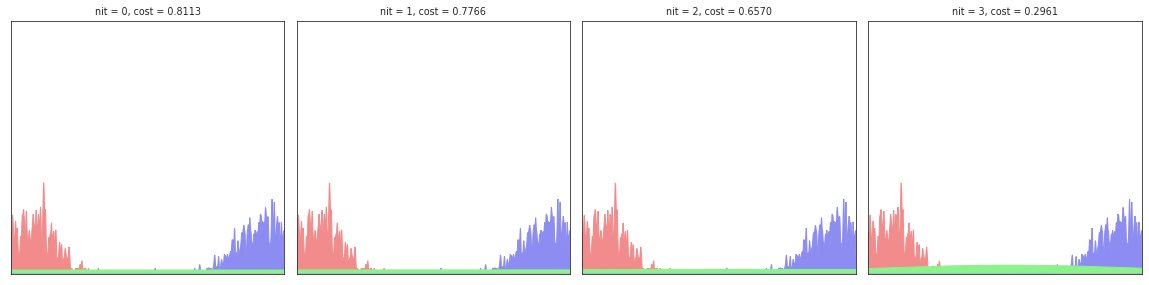

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

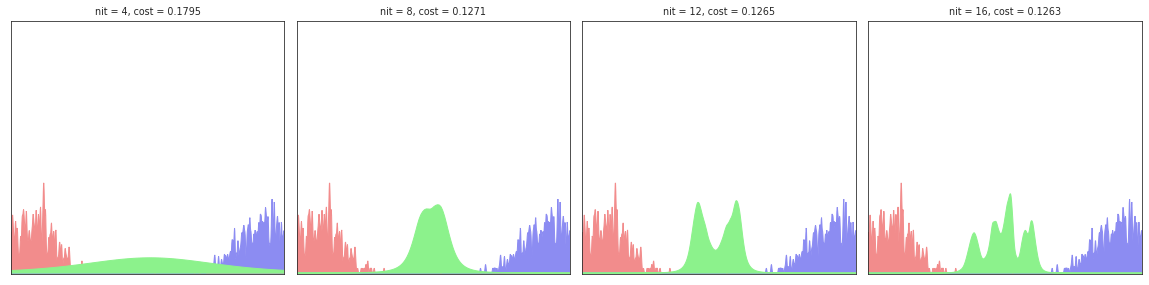

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

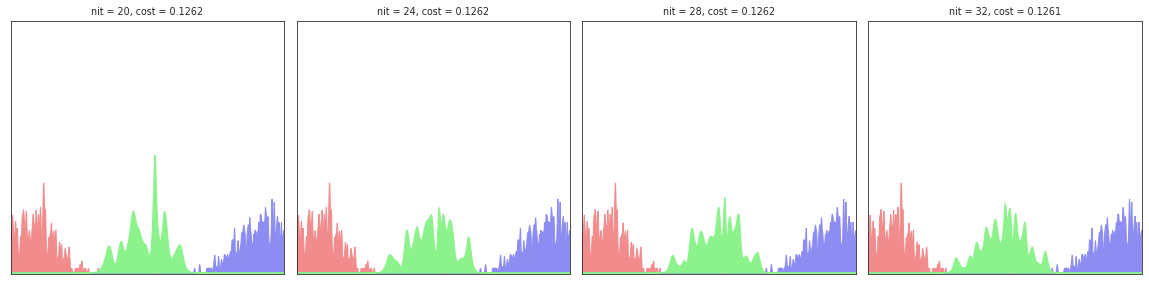

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

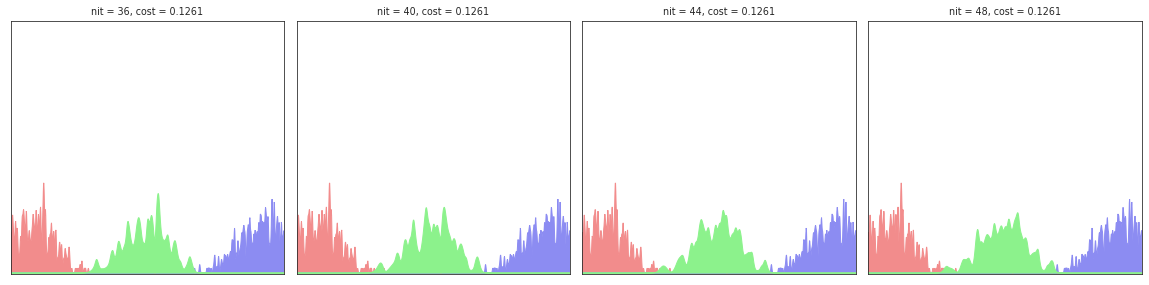

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

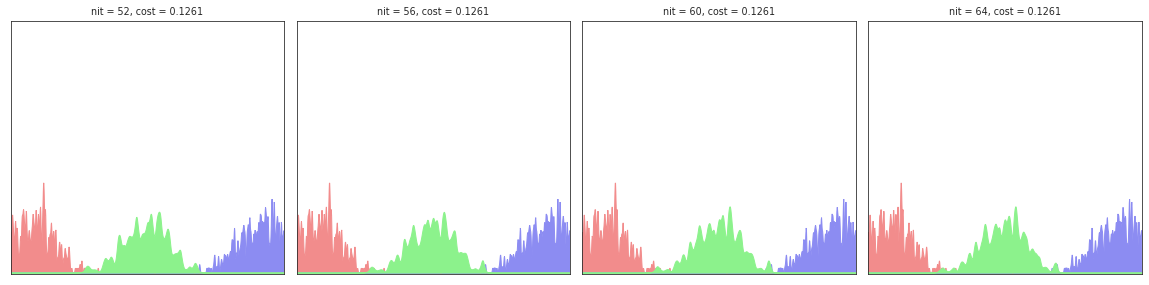

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keywor

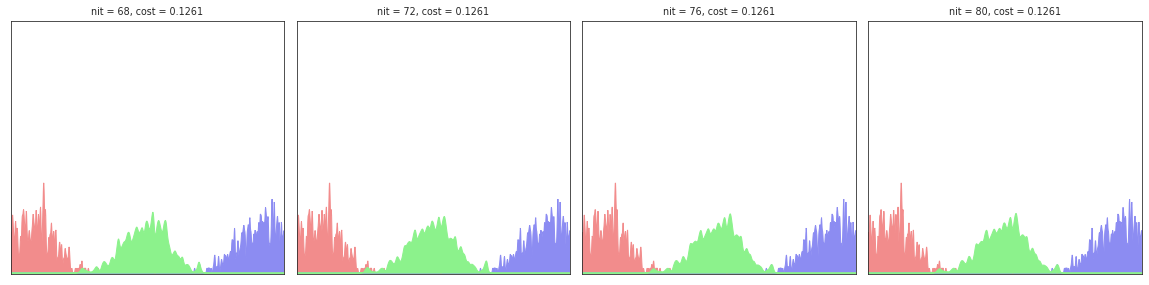

<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-27-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])


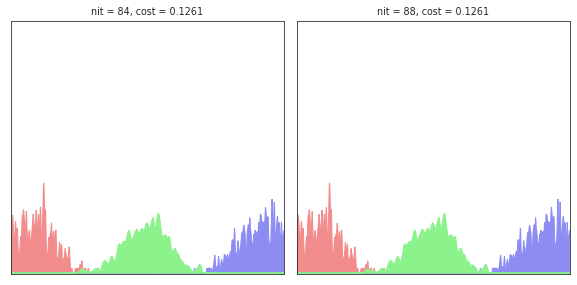

In [98]:
EB = EulerianBarycenter(SamplesLoss("sinkhorn", p=2, blur=.001, scaling=.99))
EB.fit(display=True)

/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

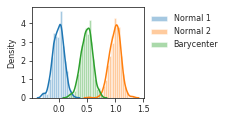

In [99]:
# get distributions out 
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.distplot(X_i, label='Normal 1', ax = ax)
sns.distplot(Y_j, label='Normal 2', ax = ax)

# get barycenter
weights = torch.nn.functional.softmax(EB.l_k, dim=0)
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 
sns.distplot(z_sampled, label='Barycenter', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(os.path.join(pfp, 'barycenter_normals.pdf'), bbox_inches='tight')

In [100]:
# add data
embeddings.loc['Normal-1', ['X', 'Y']] = model(X_i.view(1, -1, 1)).detach().numpy()
embeddings.loc['Normal-2', ['X', 'Y']] = model(Y_j.view(1, -1, 1)).detach().numpy()
embeddings.loc['Barycenter (Normals)', ['X', 'Y']] = model(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

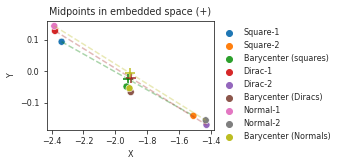

In [112]:
# plot the embedded space 

fig, ax = plt.subplots(1, 1, figsize=(3,2))

# squares
ax.plot([embeddings.loc['Square-1', 'X'], embeddings.loc['Square-2', 'X']],
         [embeddings.loc['Square-1', 'Y'], embeddings.loc['Square-2', 'Y']],
         color='green', linestyle='--', alpha=0.33)
ax.scatter((embeddings.loc['Square-1', 'X'] + embeddings.loc['Square-2', 'X'])/2,
            (embeddings.loc['Square-1', 'Y'] + embeddings.loc['Square-2', 'Y'])/2,
           color='green', marker='+', s=100)

# diracs
ax.plot([embeddings.loc['Dirac-1', 'X'], embeddings.loc['Dirac-2', 'X']],
         [embeddings.loc['Dirac-1', 'Y'], embeddings.loc['Dirac-2', 'Y']],
        color='brown', linestyle='--', alpha=0.33)
ax.scatter((embeddings.loc['Dirac-1', 'X'] + embeddings.loc['Dirac-2', 'X'])/2,
            (embeddings.loc['Dirac-1', 'Y'] + embeddings.loc['Dirac-2', 'Y'])/2,
           color='brown', marker='+', s=100)

# normals
ax.plot([embeddings.loc['Normal-1', 'X'], embeddings.loc['Normal-2', 'X']],
         [embeddings.loc['Normal-1', 'Y'], embeddings.loc['Normal-2', 'Y']],
        color=sns.color_palette()[8],
        linestyle='--', alpha=0.33)
ax.scatter((embeddings.loc['Normal-1', 'X'] + embeddings.loc['Normal-2', 'X'])/2,
            (embeddings.loc['Normal-1', 'Y'] + embeddings.loc['Normal-2', 'Y'])/2,
           color=sns.color_palette()[8], marker='+', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings.reset_index(),
                ax=ax,
                s=50)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Midpoints in embedded space (+)')
fig.savefig(os.path.join(pfp, 'barycenter_embedding+midpt.pdf'),  bbox_inches='tight')

# below is arijit code

In [26]:
EB.l_k.shape

torch.Size([100])

In [9]:
class LagrangianBarycenter(Barycenter) :
    def __init__(self, loss, w=.5) :
        super(LagrangianBarycenter, self).__init__(loss, w)

        # Our parameter to optimize: the locations of the input samples
        self.z_k = Parameter( Z_k.clone() )

    def forward(self) :
        """Returns the cost to minimize."""
        # By default, the weights are uniform and sum up to 1:
        return self.w  * self.loss( self.z_k, self.x_i) \
        + (1 - self.w) * self.loss( self.z_k, self.y_j)

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

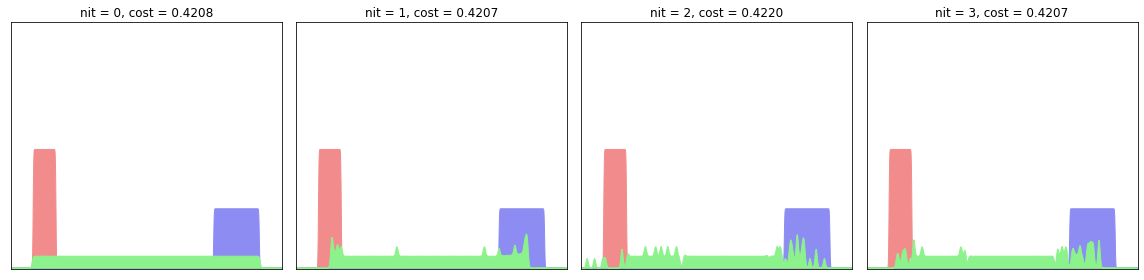

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

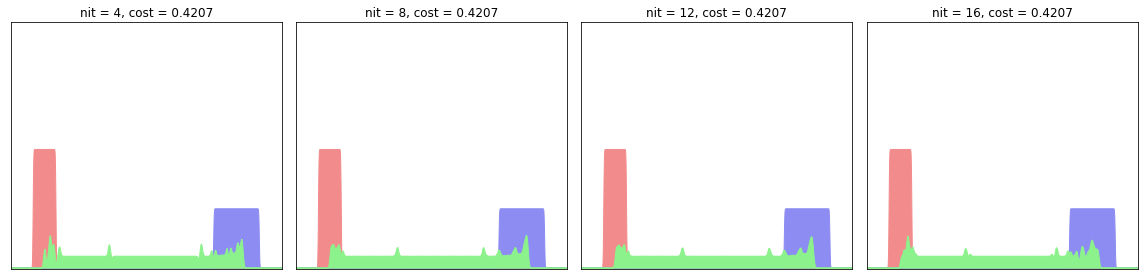

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

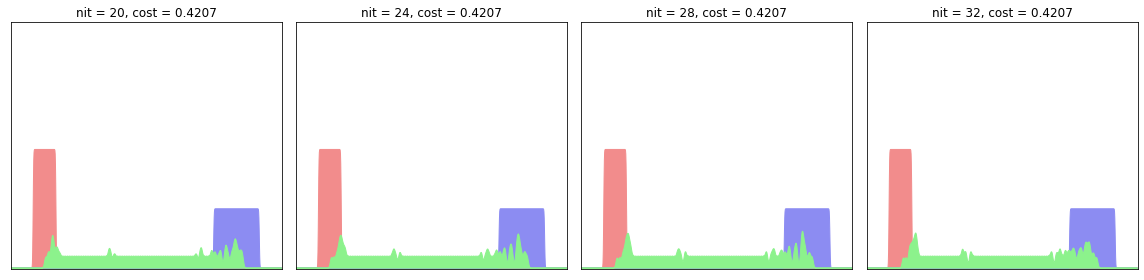

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

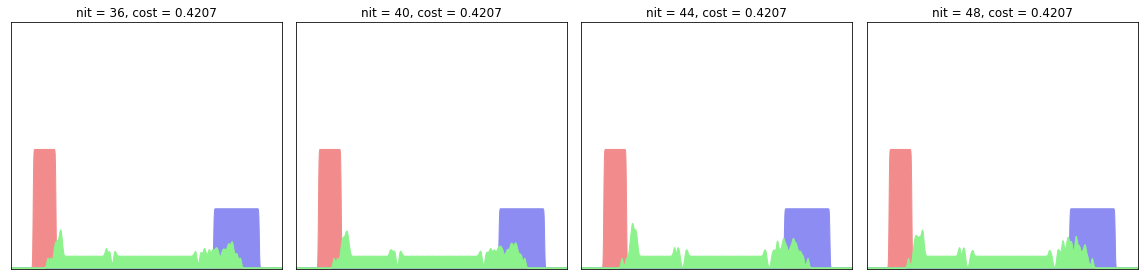

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

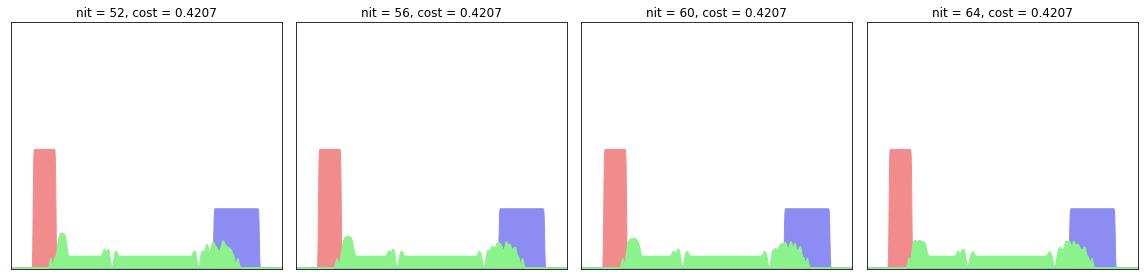

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

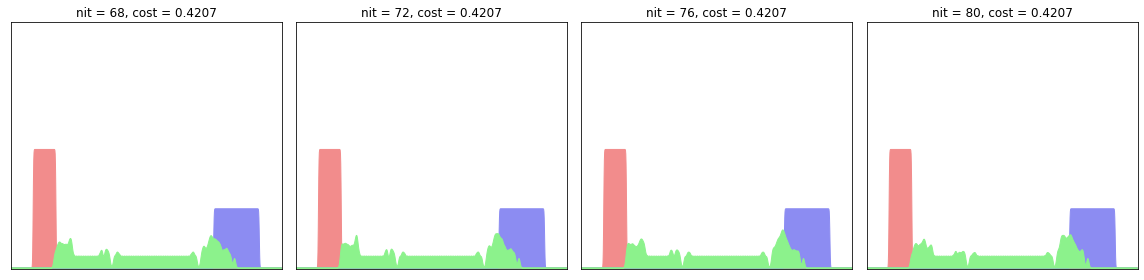

<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], []); ax.set_yticks([], [])
<ipython-input-7-8b758f21c6bd>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

Traceback (most recent call last):
  File "/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-7e516d400226>", line 1, in <module>
    LagrangianBarycenter( SamplesLoss("sinkhorn", p=1, blur=.001, scaling=.99) ).fit(display=True)
  File "<ipython-input-7-8b758f21c6bd>", line 15, in fit
    fit_model(self, method = "L-BFGS", lr = 1., display = display, tol=tol, gtol=tol)
  File "<ipython-input-6-bb3ea86f93a3>", line 112, in fit_model
    res = minimize( numpy_closure,      # function to minimize
  File "/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 617, in minimize
    return _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/scipy/optimize/lbfgsb.py", line 360, in _minimize_lbfgsb
  

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x2b4161c240d0> (for post_execute):


KeyboardInterrupt: 

In [13]:
LagrangianBarycenter( SamplesLoss("sinkhorn", p=1, blur=.001, scaling=.99) ).fit(display=True)

In [37]:
weights = torch.nn.functional.softmax(EB.l_k, dim=0)

In [39]:
weights

tensor([0.0018, 0.0018, 0.0018, 0.0021, 0.0027, 0.0028, 0.0030, 0.0030, 0.0030,
        0.0029, 0.0032, 0.0045, 0.0060, 0.0071, 0.0058, 0.0068, 0.0082, 0.0081,
        0.0075, 0.0033, 0.0036, 0.0077, 0.0117, 0.0057, 0.0075, 0.0063, 0.0029,
        0.0040, 0.0133, 0.0063, 0.0130, 0.0057, 0.0037, 0.0020, 0.0047, 0.0033,
        0.0066, 0.0085, 0.0160, 0.0133, 0.0137, 0.0088, 0.0146, 0.0096, 0.0103,
        0.0143, 0.0133, 0.0121, 0.0057, 0.0173, 0.0088, 0.0113, 0.0085, 0.0144,
        0.0169, 0.0074, 0.0121, 0.0183, 0.0087, 0.0062, 0.0207, 0.0404, 0.0066,
        0.0054, 0.0108, 0.0077, 0.0106, 0.0109, 0.0215, 0.0216, 0.0098, 0.0127,
        0.0226, 0.0122, 0.0032, 0.0121, 0.0189, 0.0179, 0.0130, 0.0070, 0.0109,
        0.0113, 0.0038, 0.0060, 0.0108, 0.0129, 0.0250, 0.0037, 0.0027, 0.0019,
        0.0021, 0.0028, 0.0069, 0.0040, 0.0047, 0.0046, 0.0056, 0.0061, 0.0063,
        0.1188], grad_fn=<SoftmaxBackward>)

In [41]:
EB.z_k

tensor([[-1.5000],
        [-1.4697],
        [-1.4394],
        [-1.4091],
        [-1.3788],
        [-1.3485],
        [-1.3182],
        [-1.2879],
        [-1.2576],
        [-1.2273],
        [-1.1970],
        [-1.1667],
        [-1.1364],
        [-1.1061],
        [-1.0758],
        [-1.0455],
        [-1.0152],
        [-0.9848],
        [-0.9545],
        [-0.9242],
        [-0.8939],
        [-0.8636],
        [-0.8333],
        [-0.8030],
        [-0.7727],
        [-0.7424],
        [-0.7121],
        [-0.6818],
        [-0.6515],
        [-0.6212],
        [-0.5909],
        [-0.5606],
        [-0.5303],
        [-0.5000],
        [-0.4697],
        [-0.4394],
        [-0.4091],
        [-0.3788],
        [-0.3485],
        [-0.3182],
        [-0.2879],
        [-0.2576],
        [-0.2273],
        [-0.1970],
        [-0.1667],
        [-0.1364],
        [-0.1061],
        [-0.0758],
        [-0.0455],
        [-0.0152],
        [ 0.0152],
        [ 0.0455],
        [ 0.

In [46]:
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())

In [47]:
z_sampled = kde.sample(100) 

In [186]:
X_i = torch.rand(100,2)
Y_j = torch.rand(100,2)
weights_i = torch.ones(100)/100
weights_j = torch.ones(100)/100
A = weights_i, X_i
B = weights_j, Y_j
#t = torch.linspace(-1.5, 1.5, 100).view(-1,1)
#Z_k = t

In [199]:
weights_i.shape

torch.Size([100])

In [57]:
LB = LagrangianBarycenter( SamplesLoss("sinkhorn", p=1, blur=.01, scaling=.9) )

In [58]:
LB.fit(display=False)

ValueError: Input samples 'x' and 'y' should have the same last dimension.

In [190]:
def grid(W):
    y, x = torch.meshgrid( [ torch.arange(0.,W) / W ] * 2 )
    return torch.stack( (x,y), dim=2 ).view(-1,2)

In [201]:
x_i = grid(10).view(-1,2)
a_i = (torch.ones(100) / (100))

x_i.requires_grad = True

In [200]:
x_i.shape

torch.Size([100, 2])

In [207]:
Loss = SamplesLoss("sinkhorn", p=1, blur=.01, scaling=.9)
models = []
for (b_j, y_j) in [A,B]:
    L_ab = Loss( a_i, x_i, b_j, y_j)
    [g_i] = torch.autograd.grad(L_ab, [x_i])
    models.append( x_i - g_i / a_i.view(-1,1) )

a, b = models


In [211]:
def gradient_flow(loss, lr=.05) :
    """Flows along the gradient of the cost function, using a simple Euler scheme.
    
    Parameters:
        loss ((x_i,y_j) -> torch float number): 
            Real-valued loss function.
        lr (float, default = .05):
            Learning rate, i.e. time step.
    """
    
    # Parameters for the gradient descent
    Nsteps = int(5/lr)+1 
    display_its = [int(t/lr) for t in [0, .25, .50, 1., 2., 5.]]
    
    # Use colors to identify the particles
    colors = (10*X_i[:,0]).cos() * (10*X_i[:,1]).cos()
    colors = colors.detach().cpu().numpy()
    
    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β) 
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True  
    
    t_0 = time.time()
    plt.figure(figsize=(12,8)) ; k = 1
    for i in range(Nsteps): # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g]  = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its : # display
            ax = plt.subplot(2,3,k) ; k = k+1
            plt.set_cmap("hsv")
            plt.scatter( [10], [10] ) # shameless hack to prevent a slight change of axis...

            display_samples(ax, y_j, [(.55,.55,.95)])
            display_samples(ax, x_i, colors)
            
            ax.set_title("t = {:1.2f}".format(lr*i))

            plt.axis([0,1,0,1])
            plt.gca().set_aspect('equal', adjustable='box')
            plt.xticks([], []); plt.yticks([], [])
            plt.tight_layout()
        
        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g 
    plt.title("t = {:1.2f}, elapsed time: {:.2f}s/it".format(lr*i, (time.time() - t_0)/Nsteps ))


ValueError: query data dimension must match training data dimension

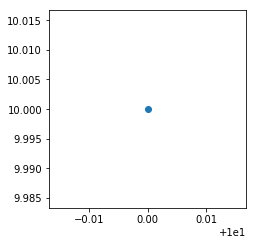

In [212]:
gradient_flow(Loss)

In [59]:
pip install cython

Note: you may need to restart the kernel to use updated packages.


In [60]:
pip install POT

     |████████████████████████████████| 430kB 5.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [61]:
import matplotlib.pylab as pl
import ot
import ot.plot


In [62]:
n = 50  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

In [63]:
xs.shape

(50, 2)

Text(0.5, 1.0, 'Source and target distributions')

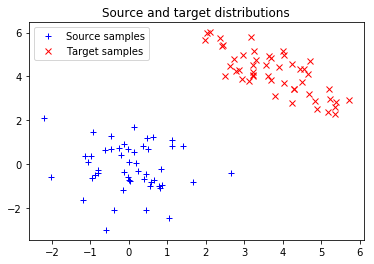

In [64]:
pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

In [66]:
b_s = np.random.uniform(0., 1., (50))
b_s = b_s / np.sum(b_s) 

In [67]:
b_t = np.random.uniform(0., 1., (50))
b_t = b_t / np.sum(b_t) 

In [81]:
all = np.concatenate((xs,xt), axis=0)
measure_loc = [x for x in all]
# measure_loc.append([x for x in xt])

In [83]:
a1 = np.concatenate((b_s,b_t), axis=0)

In [84]:
weights = [x for x in a1]

In [216]:
k = 250  # number of Diracs of the barycenter
X_init = np.random.normal(0., 1., (k, 2))  # initial Dirac locations
b = np.ones((k,)) / k  # weights of the barycenter (it will not be optimized, only the locations are optimized)

# X = ot.lp.free_support_barycenter(measures_locations, measures_weights, X_init, b)

In [225]:
N = 3
d = 2
measures_locations = []
measures_weights = []

for i in range(N):

   # n_i = np.random.randint(low=1, high=20)  # nb samples
    n_i = 250

    mu_i = np.random.normal(0., 4., (d,))  # Gaussian mean

    A_i = np.random.rand(d, d)
    cov_i = np.dot(A_i, A_i.transpose())  # Gaussian covariance matrix

    x_i = ot.datasets.make_2D_samples_gauss(n_i, mu_i, cov_i)  #Dirac locations

    b_i = np.random.uniform(0., 1., (n_i,))
    b_i = b_i / np.sum(b_i)  # Dirac weights

    measures_locations.append(x_i)
    measures_weights.append(b_i)

In [226]:
X = ot.lp.free_support_barycenter(measures_locations, measures_weights, X_init, b)

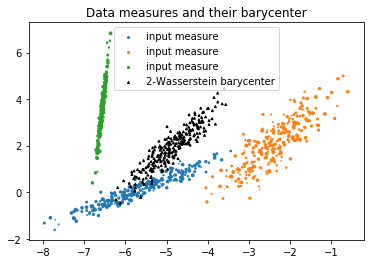

In [227]:
pl.figure(1)
for (x_i, b_i) in zip(measures_locations, measures_weights):
    color = np.random.randint(low=1, high=10 * N)
    pl.scatter(x_i[:, 0], x_i[:, 1], s=b_i * 1000, label='input measure')
pl.scatter(X[:, 0], X[:, 1], s=b * 1000, c='black', marker='^', label='2-Wasserstein barycenter')
pl.title('Data measures and their barycenter')
pl.legend(loc=0)
pl.show()

In [94]:
X.tolist()

[[-2.437791947731321, -1.7965910788298909],
 [-1.2029422815322304, -0.9732903351910664],
 [-1.5948079313345607, -1.143399843895272],
 [-1.4272595515078763, -0.47686721988181746],
 [-1.8714455193223525, -1.2673478961746123],
 [-0.13995113549126525, -0.39573869826226504],
 [-0.724379327064939, -0.43263208908846207],
 [-0.1807448758979463, 0.17691437418576372],
 [-0.9208645236405196, -0.5543549441090677],
 [-1.8764103745312488, -1.809182438206065]]

In [218]:

def free_support_barycenter(measures_locations, measures_weights, X_init, b=None, weights=None, numItermax=100,
                            stopThr=1e-7, verbose=False, log=None):
    r"""
    Solves the free support (locations of the barycenters are optimized, not the weights) Wasserstein barycenter problem (i.e. the weighted Frechet mean for the 2-Wasserstein distance), formally:

    .. math::
        \min_X \sum_{i=1}^N w_i W_2^2(b, X, a_i, X_i)

    where :

    - :math:`w \in \mathbb{(0, 1)}^{N}`'s are the barycenter weights and sum to one
    - the :math:`a_i \in \mathbb{R}^{k_i}` are the empirical measures weights and sum to one for each :math:`i`
    - the :math:`X_i \in \mathbb{R}^{k_i, d}` are the empirical measures atoms locations
    - :math:`b \in \mathbb{R}^{k}` is the desired weights vector of the barycenter

    This problem is considered in [1] (Algorithm 2). There are two differences with the following codes:

    - we do not optimize over the weights
    - we do not do line search for the locations updates, we use i.e. theta = 1 in [1] (Algorithm 2). This can be seen as a discrete implementation of the fixed-point algorithm of [2] proposed in the continuous setting.

    Parameters
    ----------
    measures_locations : list of N (k_i,d) numpy.ndarray
        The discrete support of a measure supported on k_i locations of a d-dimensional space (k_i can be different for each element of the list)
    measures_weights : list of N (k_i,) numpy.ndarray
        Numpy arrays where each numpy array has k_i non-negatives values summing to one representing the weights of each discrete input measure

    X_init : (k,d) np.ndarray
        Initialization of the support locations (on k atoms) of the barycenter
    b : (k,) np.ndarray
        Initialization of the weights of the barycenter (non-negatives, sum to 1)
    weights : (N,) np.ndarray
        Initialization of the coefficients of the barycenter (non-negatives, sum to 1)

    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True

    Returns
    -------
    X : (k,d) np.ndarray
        Support locations (on k atoms) of the barycenter

    References
    ----------

    .. [1] Cuturi, Marco, and Arnaud Doucet. "Fast computation of Wasserstein barycenters." International Conference on Machine Learning. 2014.

    .. [2]  Álvarez-Esteban, Pedro C., et al. "A fixed-point approach to barycenters in Wasserstein space." Journal of Mathematical Analysis and Applications 441.2 (2016): 744-762.

    """

    iter_count = 0

    N = len(measures_locations)
    k = X_init.shape[0]
    d = X_init.shape[1]
    if b is None:
        b = np.ones((k,)) / k
    if weights is None:
        weights = np.ones((N,)) / N

    X = X_init

    log_dict = {}
    displacement_square_norms = []

    displacement_square_norm = stopThr + 1.

    while (displacement_square_norm > stopThr and iter_count < numItermax):

        T_sum = np.zeros((k, d))

        for (measure_locations_i, measure_weights_i, weight_i) in zip(measures_locations, measures_weights,
                                                                      weights.tolist()):
            M_i = ot.dist(X, measure_locations_i, metric='cityblock')
            T_i = ot.emd(b, measure_weights_i, M_i)
            T_sum = T_sum + weight_i * np.reshape(1. / b, (-1, 1)) * np.matmul(T_i, measure_locations_i)

        displacement_square_norm = np.sum(np.abs(T_sum - X))
        if log:
            displacement_square_norms.append(displacement_square_norm)

        X = T_sum

        if verbose:
            print('iteration %d, displacement_square_norm=%f\n', iter_count, displacement_square_norm)

        iter_count += 1

    if log:
        log_dict['displacement_square_norms'] = displacement_square_norms
        return X, log_dict
    else:
        return X


In [228]:
Y = free_support_barycenter(measures_locations, measures_weights, X_init, b)

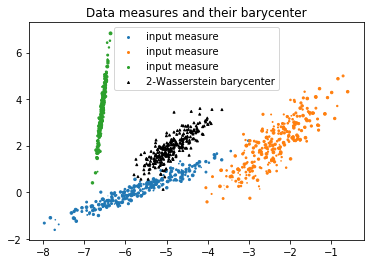

In [229]:
pl.figure(1)
for (x_i, b_i) in zip(measures_locations, measures_weights):
    color = np.random.randint(low=1, high=10 * N)
    pl.scatter(x_i[:, 0], x_i[:, 1], s=b_i * 1000, label='input measure')
pl.scatter(Y[:, 0], Y[:, 1], s=b * 1000, c='black', marker='^', label='2-Wasserstein barycenter')
pl.title('Data measures and their barycenter')
pl.legend(loc=0)
pl.show()

In [100]:
import random
import time
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
from scipy.stats import wasserstein_distance

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader

In [101]:
device = torch.device('cpu')

In [102]:
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ELU(inplace=True),
            nn.Linear(50, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 10),
            nn.ELU(inplace=True),
            nn.Linear(10, 2),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x


In [162]:
model = DeepSet(2, 36).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('normal_2D_2condition1.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

#model.train()
model.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [172]:
X_1 = torch.from_numpy(measures_locations[0])
X1 = X_1.view(1,-1,2)

In [173]:
X_2 = torch.from_numpy(measures_locations[1])
X2 = X_2.view(1,-1,2)

In [174]:
X_3 = torch.from_numpy(measures_locations[2])
X3 = X_3.view(1,-1,2)

In [175]:
model.to(torch.float)(X1.to(torch.float))

tensor([[ 4.1585, -7.1716]], grad_fn=<AddmmBackward>)

In [176]:
model(X2.to(torch.float))

tensor([[-0.9021, -7.4532]], grad_fn=<AddmmBackward>)

In [177]:
model(X3.to(torch.float))

tensor([[-2.1716, -8.1691]], grad_fn=<AddmmBackward>)

In [178]:
avg = torch.from_numpy(np.array(X.tolist()))

In [179]:
avg1 = avg.view(1,-1,2)

In [180]:
model(avg1.to(torch.float))

tensor([[ 2.1134, -1.0477]], grad_fn=<AddmmBackward>)

In [181]:
Y = free_support_barycenter(measures_locations, measures_weights, X_init, b)

In [182]:
avg2 = torch.from_numpy(np.array(Y.tolist()))

In [183]:
avg2 = avg2.view(1,-1,2)

In [184]:
model(avg2.to(torch.float))

tensor([[ 2.0536, -1.0157]], grad_fn=<AddmmBackward>)